1. Create conda env with GPU
2. Create data generator with augmentation
3. Create simple model
4. create advanced model with Bayesian Optimization for Hyperparameter tuning

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import segmentation_models as sm
import glob
%reload_ext autoreload
%autoreload 2



Segmentation Models: using `keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [3]:
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 4647016815106826782,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 9883877376
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 17077319367266561774
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3080 Ti, pci bus id: 0000:01:00.0, compute capability: 8.6"]

In [4]:
NUM_CLASSES = 34
IMAGE_SIZE = (256, 256, 3)
BATCH_SIZE = 20

In [5]:
def display_batch_of_images(batch):
  import matplotlib.pyplot as plt

  for i in range(len(batch[0])):

    image = batch[0][i]

    # normalize to [0,1]
    image =  (image - np.min(image)) / (np.max(image) - np.min(image) + 1e-9)

    segmentation = tf.math.argmax(batch[1][i], axis=-1) # undo to_categorical

    segmentation = tf.cast(segmentation, tf.float32)
    segmentation = tf.multiply((255.0 / NUM_CLASSES), segmentation)
    segmentation = segmentation / 255.0

    plt.figure()

    plt.subplot(1, 2, 1)
    plt.imshow(image)
    plt.title('Image')

    plt.subplot(1, 2, 2)
    plt.imshow(segmentation, vmin=0, vmax=1)
    plt.title('Ground Truth Segmentation')

    plt.show()

In [6]:
DATA_FOLDER = f"data"

In [7]:
import albumentations as A
from data_generator import SegmentationDataGenerator

aug = A.Compose([
        #A.VerticalFlip(p=0.5),              
        A.RandomRotate90(p=0.5),
        #A.PixelDropout(p=0.01),
        #A.OneOf([
        #    A.MotionBlur(p=0.2),
        #    A.Blur(p=0.1),
        #], p=0.2),
        A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=20, p=0.2),
        #A.OpticalDistortion(p=0.3),
        #A.GridDistortion(p=.1),
        #A.RandomBrightnessContrast(p=0.4)
    ]
)

train_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/train/train2/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/train/train2/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = aug
)
train_data_gen = train_data.get_data_generator()

val_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/val/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/val/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
val_data_gen = val_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 23520 images with 23520 segmentations
Indexing Image files...
Indexing Segmentation files...
Loaded 8544 images with 8544 segmentations


# Print examples

In [8]:
batch = train_data_gen.__next__()
display_batch_of_images(batch)

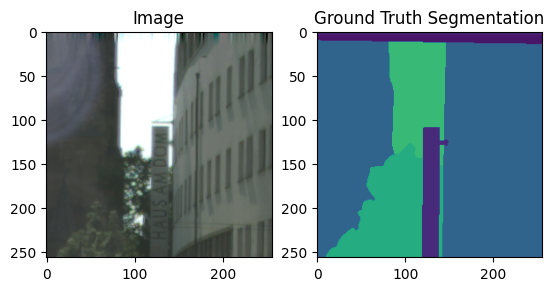

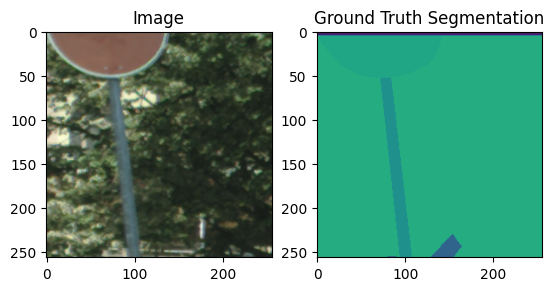

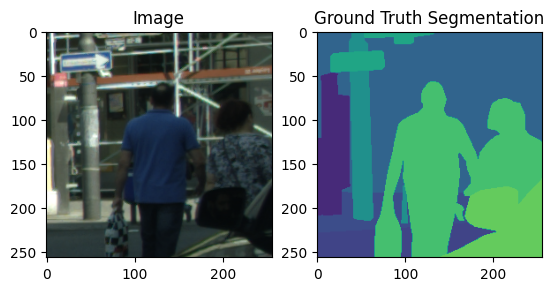

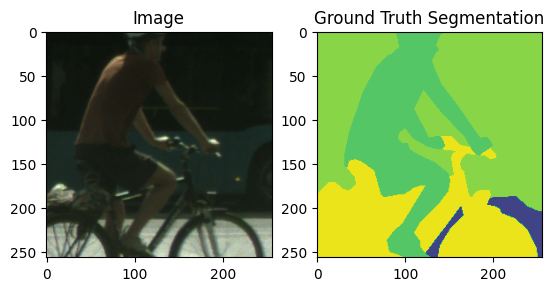

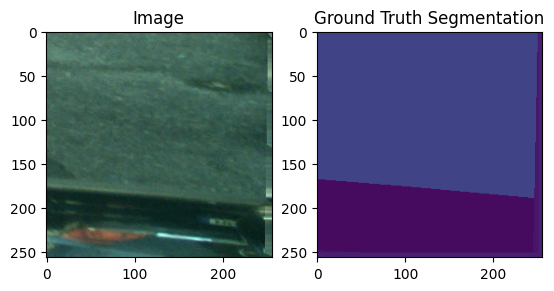

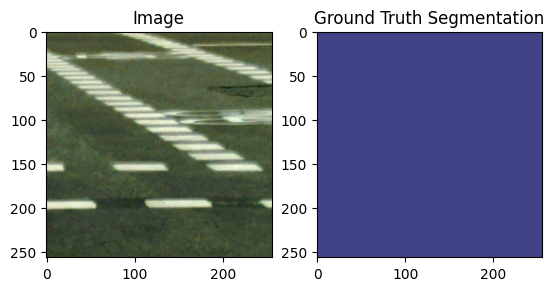

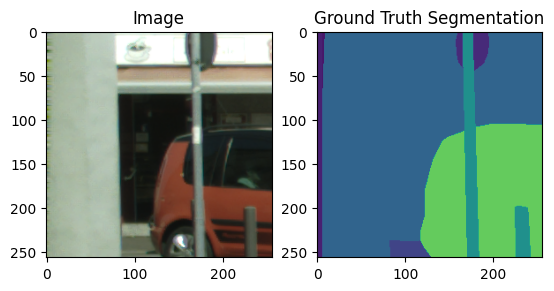

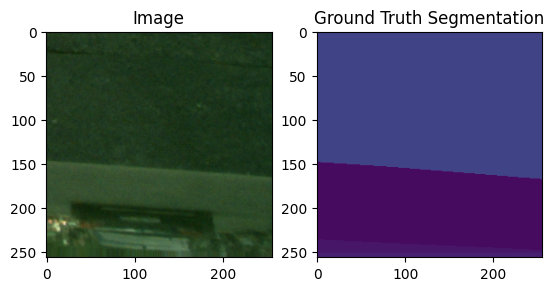

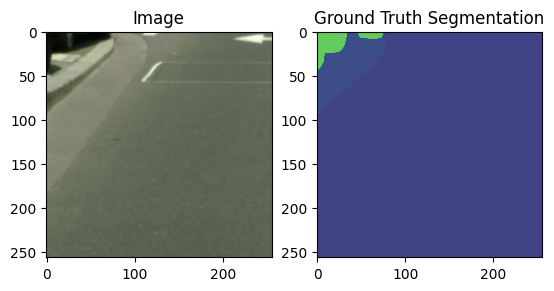

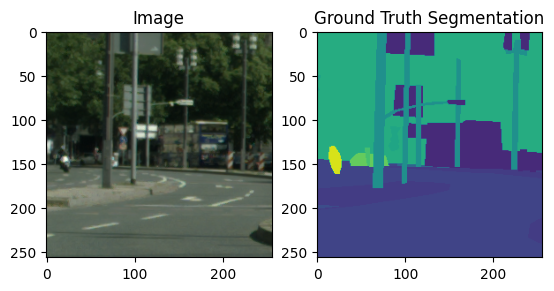

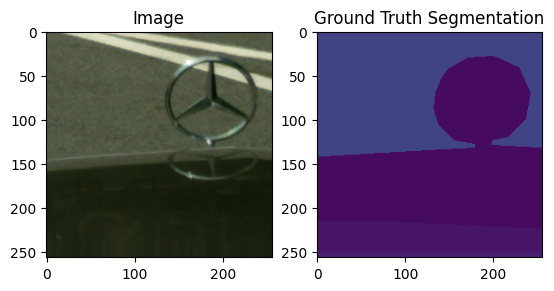

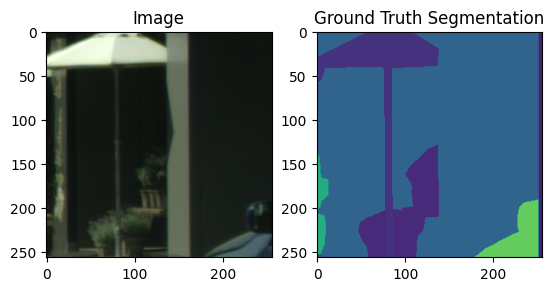

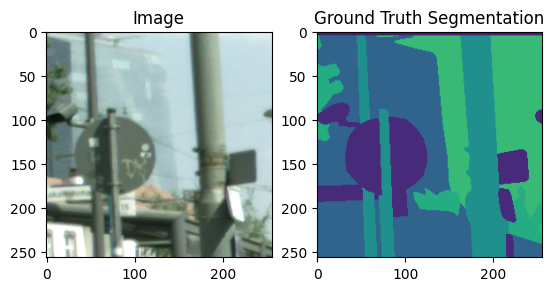

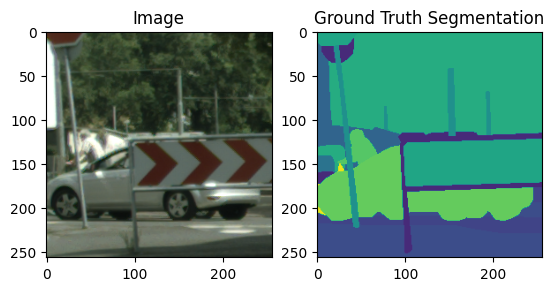

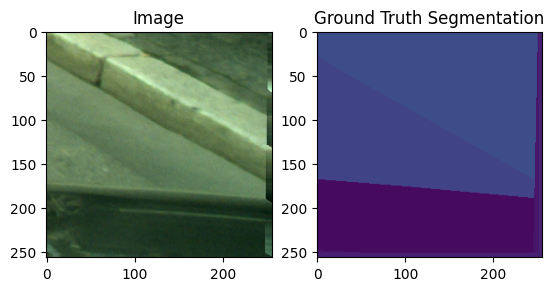

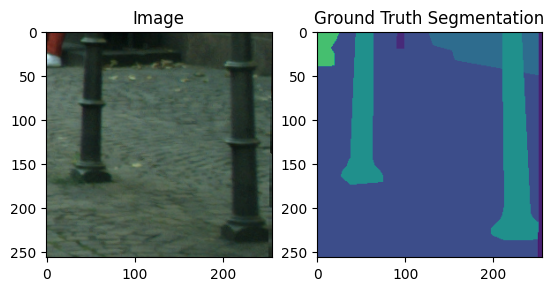

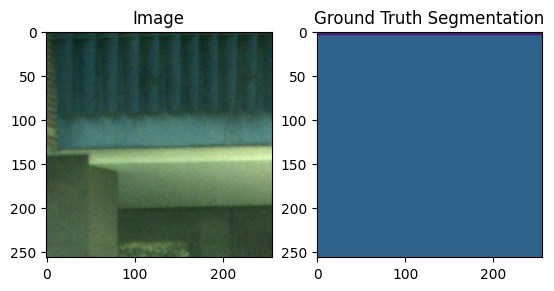

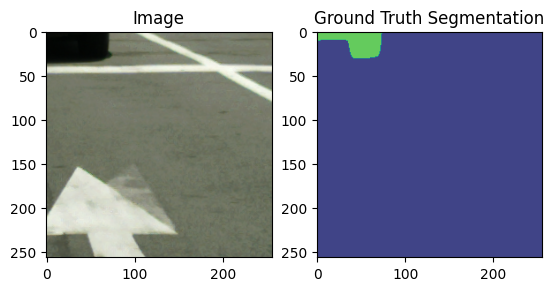

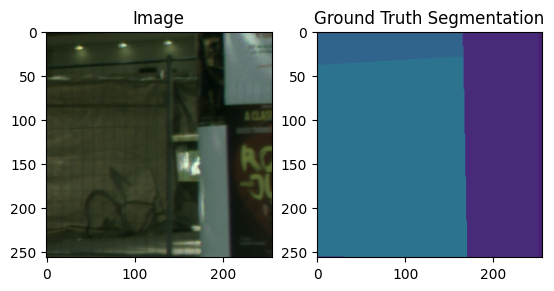

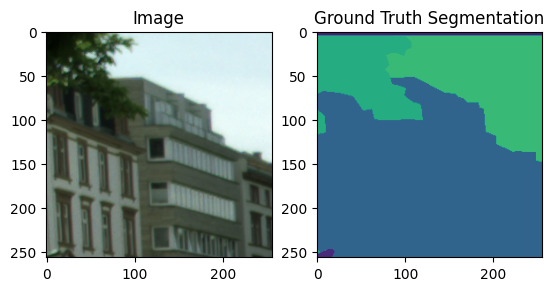

In [ ]:
batch = val_data_gen.__next__()
display_batch_of_images(batch)

# Define Model

In [ ]:
def fcn_simple_no_border(input_height:int, input_width:int, input_channels:int, num_classes:int) -> tf.keras.Model:
    """
    Create a simple fcn model for semantic segmentation with 2 classes
    """
    model = tf.keras.Sequential()
    
    # (used to define input shape on the first layers)
    model.add(tf.keras.layers.Layer(input_shape=(input_height , input_width, input_channels)))
    
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=64, kernel_size=3, strides=(1, 1), padding='same', activation='relu'))

    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    model.add(tf.keras.layers.Convolution2D(filters=32, kernel_size=1, strides=1, padding='same', activation='relu'))
    
    model.add(tf.keras.layers.Convolution2D(filters=num_classes, kernel_size=3, strides=(1, 1), padding='same', activation='softmax'))
    
    return model

In [ ]:
#model = fcn_simple_no_border(IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2], NUM_CLASSES)

In [ ]:
from unet import build_unet

model = build_unet(NUM_CLASSES, IMAGE_SIZE[0], IMAGE_SIZE[1], IMAGE_SIZE[2] )

In [ ]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 256, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 256, 256, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

## Calculate Class weights for loss

In [ ]:
#tf.keras.utils.plot_model(model)

In [ ]:
x, y = train_data_gen.__next__()

print(x.shape)
print(y.shape)

(20, 256, 256, 3)
(20, 256, 256, 34)


In [ ]:
_, y = train_data_gen.__next__()

total_values = y.shape[1] * y.shape[2] * y.shape[3]

class_counts = np.zeros(NUM_CLASSES)

n = 5

for _ in range(n):

    _, y = train_data_gen.__next__()

    #undo keras.to_categorical
    y = np.argmax(y, axis=-1)

    indexes = np.unique(y, return_counts=True)[0]
    counts = np.unique(y, return_counts=True)[1]
    for index, count in zip(indexes, counts):
        class_counts[index-1] += count

    
class_weights = np.asarray(class_counts)
class_weights = np.divide(class_weights, total_values*n)
class_weights = np.sum(class_weights) - class_weights
class_weights = np.divide(class_weights, np.sum(class_weights))
    
print(f"Class weights: {class_weights}")
print(np.sum(class_weights))

Class weights: [0.02831376 0.0291739  0.02986098 0.02986643 0.03025663 0.0297876
 0.0199984  0.02893815 0.03006148 0.03027974 0.02481364 0.03006011
 0.03004355 0.03030303 0.03030303 0.03030303 0.02998162 0.03030303
 0.0302761  0.03021262 0.02728243 0.03021767 0.02892501 0.02979388
 0.03017709 0.0284185  0.03029825 0.03030272 0.02999588 0.03030303
 0.03030303 0.03030303 0.03023989 0.03030277]
0.9999999999999999


In [ ]:
import tensorflow.keras.backend as K

def dice_coef(y_true, y_pred, smooth=1):
    """
    Dice = (2*|X & Y|)/ (|X|+ |Y|)
         =  2*sum(|A*B|)/(sum(A^2)+sum(B^2))
    ref: https://arxiv.org/pdf/1606.04797v1.pdf
    """
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    return (2. * intersection + smooth) / (K.sum(K.square(y_true),-1) + K.sum(K.square(y_pred),-1) + smooth)

def dice_coef_loss(y_true, y_pred):
    return 1-dice_coef(y_true, y_pred)


# ----------------
# taken from: https://github.com/umbertogriffo/focal-loss-keras/blob/master/src/loss_function/losses.py
# ----------------
def categorical_focal_loss(alpha, gamma=2.):
    """
    Softmax version of focal loss.
    When there is a skew between different categories/labels in your data set, you can try to apply this function as a
    loss.
           m
      FL = ∑  -alpha * (1 - p_o,c)^gamma * y_o,c * log(p_o,c)
          c=1
      where m = number of classes, c = class and o = observation
    Parameters:
      alpha -- the same as weighing factor in balanced cross entropy. Alpha is used to specify the weight of different
      categories/labels, the size of the array needs to be consistent with the number of classes.
      gamma -- focusing parameter for modulating factor (1-p)
    Default value:
      gamma -- 2.0 as mentioned in the paper
      alpha -- 0.25 as mentioned in the paper
    References:
        Official paper: https://arxiv.org/pdf/1708.02002.pdf
        https://www.tensorflow.org/api_docs/python/tf/keras/backend/categorical_crossentropy
    Usage:
     model.compile(loss=[categorical_focal_loss(alpha=[[.25, .25, .25]], gamma=2)], metrics=["accuracy"], optimizer=adam)
    """

    alpha = np.array(alpha, dtype=np.float32)

    def categorical_focal_loss_fixed(y_true, y_pred):
        """
        :param y_true: A tensor of the same shape as `y_pred`
        :param y_pred: A tensor resulting from a softmax
        :return: Output tensor.
        """

        # Clip the prediction value to prevent NaN's and Inf's
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)

        # Calculate Cross Entropy
        cross_entropy = -y_true * K.log(y_pred)

        # Calculate Focal Loss
        loss = alpha * K.pow(1 - y_pred, gamma) * cross_entropy

        # Compute mean loss in mini_batch
        return K.mean(K.sum(loss, axis=-1))

    return categorical_focal_loss_fixed


In [ ]:
def dice_coef(y_true, y_pred, smooth=1e-8):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
    return dice

def dice_coef_multilabel(y_true, y_pred, M, smooth=1e-8):
    dice = 0
    for index in range(M):
        dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index], smooth)
    return dice

def dice_coef_multilabel_loss(y_true, y_pred, smooth=1e-8):
    return 1 - dice_coef_multilabel(y_true, y_pred, smooth)

class dice_metric:
    def dice_coef(y_true, y_pred, smooth=1e-8):
        y_true_f = K.flatten(y_true)
        y_pred_f = K.flatten(y_pred)
        intersection = K.sum(y_true_f * y_pred_f)
        dice = (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)
        return dice

    def dice_coef_multilabel(y_true, y_pred, M, smooth=1e-8):
        dice = 0
        for index in range(M):
            dice += dice_coef(y_true[:,:,:,index], y_pred[:,:,:,index], smooth)
        return dice

In [ ]:
dice_loss = sm.losses.DiceLoss(class_weights = class_weights)
focal_loss = sm.losses.CategoricalFocalLoss(
                                alpha = class_weights,
                                gamma = 2.0
                    )
total_loss = dice_loss + focal_loss

In [ ]:
import wandb
from wandb.keras import WandbMetricsLogger, WandbModelCheckpoint

In [ ]:
LEARNING_RATE = 0.05
STEPS_PER_EPOCH = len(train_data) // BATCH_SIZE

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=LEARNING_RATE,
    decay_steps=STEPS_PER_EPOCH * 4,
    decay_rate=0.95)

In [ ]:
!set WANDB_NOTEBOOK_NAME = "01_simple_model.ipynb"

In [ ]:
# Start a run, tracking hyperparameters
wandb.init(
    # set the wandb project where this run will be logged
    project="TSM-CompVis-Segmentation",

    # track hyperparameters and run metadata with wandb.config
    config={
        "optimizer": "Adam",
        "learning_rate": f"{LEARNING_RATE}",
        "loss": "categorical_cross_entropy",
        "batch_size": BATCH_SIZE,
        "steps_per_epoch": STEPS_PER_EPOCH,
        "metric": "Accuracy"
    }
)


Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: cyfi. Use `wandb login --relogin` to force relogin


In [ ]:
MODEL_NAME = wandb.run.name

In [ ]:
# Define callbacks.

checkpoint_cb = tf.keras.callbacks.ModelCheckpoint(
    "training/"+MODEL_NAME+"/checkpoints/epoch_{epoch}_val_loss_{val_loss}.keras",
    monitor='val_loss',
    save_best_only=True
)

tensorboard_cb = tf.keras.callbacks.TensorBoard(
    log_dir=f"training/{MODEL_NAME}/tensorboard",
    histogram_freq=1,
    write_graph=True
)

In [ ]:
metrics = [
        #sm.metrics.IOUScore(class_weights = class_weights ),
        #sm.metrics.FScore(class_weights = class_weights ),
        tf.keras.metrics.CategoricalAccuracy(),
        #dice_coef_multilabel
    ]

loss = tf.keras.losses.CategoricalCrossentropy()


optimizer = tf.keras.optimizers.Adam(
    learning_rate=lr_schedule,
)


model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [ ]:


history = model.fit(x=train_data_gen, validation_data=val_data_gen, validation_steps=(len(val_data) // (BATCH_SIZE*4)), validation_batch_size=BATCH_SIZE, steps_per_epoch=STEPS_PER_EPOCH, batch_size=BATCH_SIZE, epochs=50, callbacks=[checkpoint_cb, WandbMetricsLogger(log_freq=200)])

Epoch 1/50
1176/1176 [==============================] - 262s 218ms/step - loss: 35035.8516 - categorical_accuracy: 0.1835 - val_loss: 14.5075 - val_categorical_accuracy: 0.2322


c:\Users\cyril\.conda\envs\tensorflow_gpu\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/50
 282/1176 [======>.......................] - ETA: 3:55 - loss: 15.3831 - categorical_accuracy: 0.2363

In [ ]:
test_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/test/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/test/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
test_data_gen = test_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 1888 images with 1888 segmentations


In [ ]:
x, y = test_data_gen.__next__()

In [ ]:
iou_score = sm.metrics.IOUScore()

f_score = sm.metrics.FScore()

In [ ]:

model = tf.keras.models.load_model(f"training/sleek-sponge-45/checkpoints/epoch_7_val_loss_0.9851253032684326.keras", compile=False)

In [ ]:
import pandas as pd
from tqdm import tqdm

class_index = 1

IoU_df = pd.DataFrame()
FScore_df = pd.DataFrame()
Accuracy_df = pd.DataFrame()

predicted_fscores = []
predicted_ious = []
predicted_accuracies = []

for _ in tqdm(range(len(test_data) // (BATCH_SIZE * 10))):

    x, ground_truth = test_data_gen.__next__()
    
    predicted = model.predict(x)
    #predicted = ground_truth
    

    # ----- calc IoU -----
    iou_predicted = iou_score.__call__(ground_truth, predicted)
    predicted_ious.append(iou_predicted.numpy())

    # ----- calc FScore -----
    fscore_predicted = f_score.__call__(ground_truth, predicted)
    predicted_fscores.append(fscore_predicted.numpy())

    # ----- calc Accuracy -----
    m = tf.keras.metrics.CategoricalAccuracy()
    m.update_state(ground_truth, predicted)
    predicted_accuracies.append(m.result().numpy())
    
FScore_df[f'FScore'] = predicted_fscores
IoU_df[f'IoU'] = predicted_ious
Accuracy_df[f'Accuracy'] = predicted_accuracies

    
# add the two score dataframes horizontally
metrics_df = pd.concat([FScore_df, IoU_df, Accuracy_df], axis=1)

100%|██████████| 9/9 [00:03<00:00,  2.45it/s]


In [ ]:
metrics_df

,FScore,IoU,Accuracy
0,0.097228,0.062159,0.487328
1,0.097243,0.062711,0.461732
2,0.085546,0.060300,0.564605
3,0.091638,0.059736,0.499826
4,0.073785,0.049221,0.451893
...,...,...,...
89,0.073266,0.048473,0.468616
90,0.090894,0.061352,0.627032
91,0.077430,0.050597,0.530663
92,0.073471,0.047149,0.440010


In [ ]:
metrics_df.describe()

,FScore,IoU,Accuracy
count,94.000000,94.000000,94.000000
mean,0.090326,0.060724,0.539681
std,0.012462,0.009723,0.074170
min,0.064961,0.041951,0.323806
25%,0.080784,0.053820,0.481847
50%,0.089080,0.059704,0.541381
75%,0.098455,0.066846,0.591569
max,0.136198,0.095333,0.691798


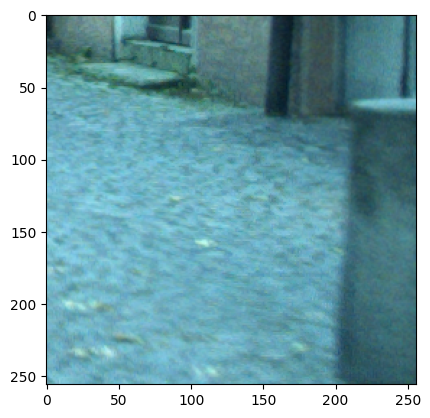

In [ ]:
plt.imshow(x[0,:,:])

In [ ]:
y_pred = model.predict(x)

Text(0.5, 1.0, 'Predicted')

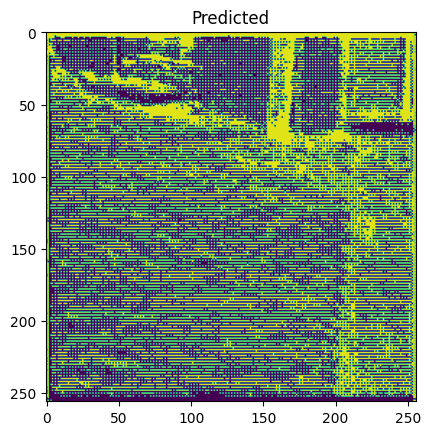

In [ ]:
seg = y_pred[0]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('Predicted')

In [ ]:
seg

array([[14, 27, 27, ..., 27, 27, 24],
       [28, 27, 27, ..., 27, 24, 26],
       [28, 27, 27, ..., 27, 27, 10],
       ...,
       [ 8, 27,  8, ...,  8, 26, 26],
       [ 8,  8,  8, ...,  8,  8,  8],
       [ 8, 26,  8, ...,  8, 26, 26]], dtype=int64)

Text(0.5, 1.0, 'GT')

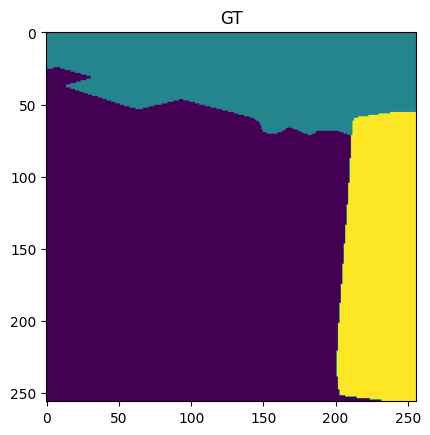

In [ ]:
seg = y[0]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('GT')

In [ ]:
seg

array([[21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       [21, 21, 21, ..., 21, 21, 21],
       ...,
       [20, 20, 20, ...,  8,  8,  8],
       [20, 20, 20, ...,  8,  8,  8],
       [20, 20, 20, ...,  8,  8,  8]], dtype=int64)

In [ ]:
test_data = SegmentationDataGenerator(
    image_directory = f"{DATA_FOLDER}/test/*_img_*",
    segmentation_directory = f"{DATA_FOLDER}/test/*_lbl_*",
    num_classes = NUM_CLASSES,
    batch_size = BATCH_SIZE,
    augmentation = False
)
test_data_gen = test_data.get_data_generator()

Indexing Image files...
Indexing Segmentation files...
Loaded 1888 images with 59 segmentations


In [ ]:
x, y = val_data_gen.__next__()
y_pred = model.predict(x)

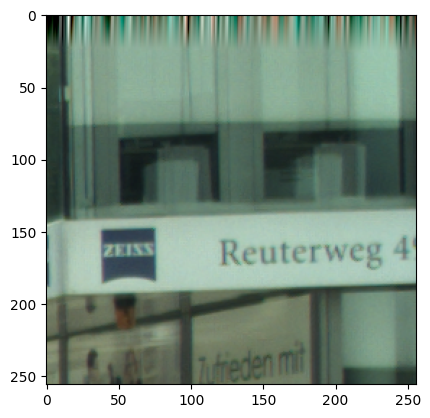

In [ ]:
plt.imshow(x[1,:,:])

Text(0.5, 1.0, 'Predicted')

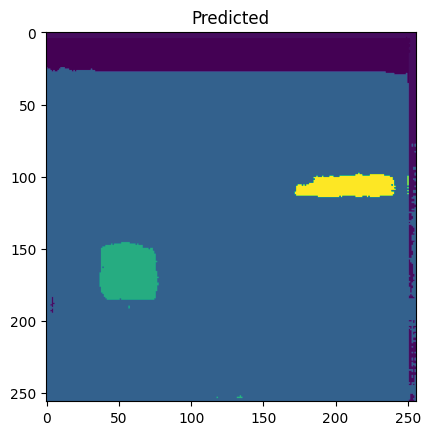

In [ ]:
seg = y_pred[1]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('Predicted')

Text(0.5, 1.0, 'GT')

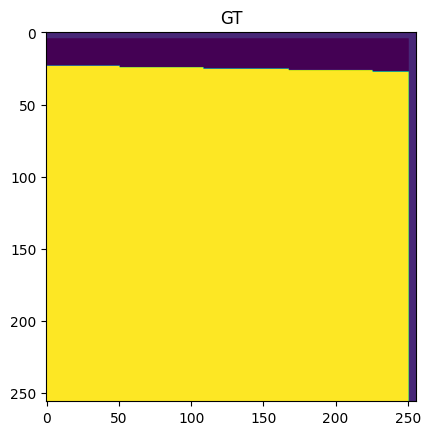

In [ ]:
seg = y[1]


#undo keras.to_categorical
seg = np.argmax(seg, axis=-1)

plt.imshow(seg)
plt.title('GT')